In [1]:
import numpy
from matplotlib import pyplot
import ipywidgets

%matplotlib inline

In [2]:
pyplot.rc('font', family = 'serif', size = 16)

In [3]:
def rho_red_light(x, rho_max):
    rho = numpy.full_like(x, rho_max) #create a array with the same size as x and set everything as rho_max
    # same as rho = rho_max * numpy.ones_like(x)
    mask = numpy.where(x<3.0)
    rho[mask] /= 2 # same as rho[mask] = rho_max/2
    return rho

In [4]:
#set parameters
nx = 81
L = 4.0
dx = L/(nx - 1)
x = numpy.linspace(0.0, L, nx)

rho_max = 10.0
u_max = 1.0
rho0 = rho_red_light(x, rho_max)

In [5]:
def plot(n, x, rho_hist):
    pyplot.figure()
    pyplot.grid()
    pyplot.title('Time step: {}'. format(n))
    pyplot.xlabel('Road [Km]')
    pyplot.ylabel('Traffic density [cars/hr]')
    pyplot.plot(x, rho_hist[n])
    pyplot.xlim(x[0],x[-1])
    pyplot.ylim(4.0, 11.0)
    pyplot.show()

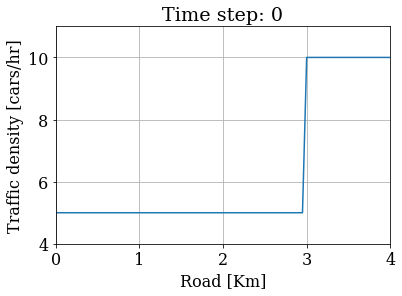

In [6]:
plot(0,x,[rho0])

In [7]:
def traffic_speed(rho, u_max, rho_max):
    return u_max * (1-rho/rho_max)

def traffic_flux(rho, u_max, rho_max):
    return rho*traffic_speed(rho, u_max, rho_max)

In [8]:
def interactive_plot(x, rho_hist):
    nt  = len(rho_hist)-1
    nt_slider = ipywidgets.IntSlider(value=0, min=0, max=nt, step=1, description='Time step')
    w = ipywidgets.interactive(plot, n=nt_slider, x = ipywidgets.fixed(x), rho_hist=ipywidgets.fixed(rho_hist))
    return w

In [9]:
interactive_plot(x,[rho0])

interactive(children=(IntSlider(value=0, description='Time step', max=0), Output()), _dom_classes=('widget-interact',))

In [10]:
def lax_friedrichs(rho0, nt, dt, dx, u_max, rho_max):
    rho_hist = [rho0.copy()]
    rho = rho0.copy()
    #nx = rho0.size
    for n in range(nt):
        rho[1:-1] = 0.5* (rho[:-2]+rho[2:]) - dt/(2*dx)*(traffic_flux(rho[2:],u_max,rho_max)-traffic_flux(rho[:-2],u_max,rho_max))
        #other methods
        #F = traffic_flux(rho, u_max, rho_max)
        #for i in range(1 , nx-1):
        #    rho[i] = (0.5*(rho[i-1]+rho[i+1])- dt*(F[i+1]-F[i-1])/(2*dx))
        #F = traffic_flux(rho, u_max, rho_max)
        #rho[1:-1] = (0.5*rho[:-2]+ rho[2:])-dt*(F[2:]-F[:-2])/dx)
        rho_hist.append(rho.copy())
    return rho_hist

In [11]:
nt = 40
sigma = 1.0
dt = sigma*dx/u_max
rho_hist = lax_friedrichs(rho0, nt, dt, dx, u_max, rho_max)
interactive_plot(x, rho_hist)

interactive(children=(IntSlider(value=0, description='Time step', max=40), Output()), _dom_classes=('widget-interact',))

In [12]:
sigma = 0.5
dt = sigma*dx/u_max
nt = 80
rho_hist = lax_friedrichs(rho0, nt, dt, dx, u_max, rho_max)
interactive_plot(x, rho_hist)

interactive(children=(IntSlider(value=0, description='Time step', max=80), Output()), _dom_classes=('widget-interact',))

In [13]:
def traffic_jacobian(rho, u_max, rho_max):
    J = u_max*(1-2*rho/rho_max)
    return J

def lax_wendroff(rho0, nt, dt, dx, u_max, rho_max):
    rho_hist = [rho0.copy()]
    rho = rho0.copy()
    for n in range(nt):
        F = traffic_flux(rho, u_max, rho_max)
        J = traffic_jacobian(rho, u_max, rho_max)
        rho[1:-1] = (rho[1:-1]-dt/(2*dx)*(F[2:]-F[:-2]) + 
                     dt**2/(4*dx**2)*((J[1:-1]+ J[2:])*(F[2:]-F[1:-1])-
                                      (J[:-2]+ J[1:-1])*(F[1:-1]-F[:-2])))
        rho_hist.append(rho.copy())
    return rho_hist

In [14]:
sigma = 1
dt = sigma*dx/u_max
nt = 40
rho_hist = lax_wendroff(rho0, nt, dt, dx, u_max, rho_max)
interactive_plot(x, rho_hist)

interactive(children=(IntSlider(value=0, description='Time step', max=40), Output()), _dom_classes=('widget-interact',))

In [15]:
sigma = 0.5
dt = sigma*dx/u_max
nt = 80
rho_hist = lax_wendroff(rho0, nt, dt, dx, u_max, rho_max)
interactive_plot(x, rho_hist)

interactive(children=(IntSlider(value=0, description='Time step', max=80), Output()), _dom_classes=('widget-interact',))

In [16]:
def maccormack(rho0, nt, dt, dx, u_max, rho_max):
    rho_hist = [rho0.copy()]
    rho = rho0.copy()
    rho_star = rho.copy()
    for n in range(nt):
        F = traffic_flux(rho, u_max, rho_max)
        rho_star[1:-1] = rho[1:-1]-dt/dx*(F[2:]-F[1:-1])
        F_star = traffic_flux(rho_star, u_max, rho_max)
        rho[1:-1] = 0.5*(rho[1:-1]+rho_star[1:-1]-dt/dx*(F_star[1:-1]-F[:-2]))
        rho_hist.append(rho.copy())
    return rho_hist

In [17]:
sigma = 1
dt = sigma*dx/u_max
nt = 40
rho_hist = maccormack(rho0, nt, dt, dx, u_max, rho_max)
interactive_plot(x, rho_hist)

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in multiply
  """
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in subtract
  import sys
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in subtract
  if __name__ == '__main__':


interactive(children=(IntSlider(value=0, description='Time step', max=40), Output()), _dom_classes=('widget-interact',))

In [18]:
sigma = 0.5
dt = sigma*dx/u_max
nt = 80
rho_hist = maccormack(rho0, nt, dt, dx, u_max, rho_max)
interactive_plot(x, rho_hist)

interactive(children=(IntSlider(value=0, description='Time step', max=80), Output()), _dom_classes=('widget-interact',))

In [19]:
rho0 = numpy.full_like(x, rho_max) 
mask = numpy.where(x<3.0)
rho0[mask] = rho_max/2-2

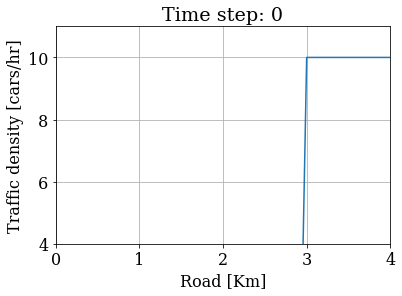

In [20]:
plot(0,x,[rho0])

In [21]:
nt = 40
sigma = 1.0
dt = sigma*dx/u_max
rho_hist = lax_friedrichs(rho0, nt, dt, dx, u_max, rho_max)
interactive_plot(x, rho_hist)

interactive(children=(IntSlider(value=0, description='Time step', max=40), Output()), _dom_classes=('widget-interact',))

In [22]:
sigma = 0.5
dt = sigma*dx/u_max
nt = 80
rho_hist = lax_friedrichs(rho0, nt, dt, dx, u_max, rho_max)
interactive_plot(x, rho_hist)

interactive(children=(IntSlider(value=0, description='Time step', max=80), Output()), _dom_classes=('widget-interact',))

In [23]:
sigma = 1
dt = sigma*dx/u_max
nt = 40
rho_hist = lax_wendroff(rho0, nt, dt, dx, u_max, rho_max)
interactive_plot(x, rho_hist)

interactive(children=(IntSlider(value=0, description='Time step', max=40), Output()), _dom_classes=('widget-interact',))

In [24]:
sigma = 0.5
dt = sigma*dx/u_max
nt = 80
rho_hist = lax_wendroff(rho0, nt, dt, dx, u_max, rho_max)
interactive_plot(x, rho_hist)

interactive(children=(IntSlider(value=0, description='Time step', max=80), Output()), _dom_classes=('widget-interact',))

In [25]:
sigma = 1
dt = sigma*dx/u_max
nt = 40
rho_hist = maccormack(rho0, nt, dt, dx, u_max, rho_max)
interactive_plot(x, rho_hist)

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in multiply
  """
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in subtract
  import sys
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in subtract
  if __name__ == '__main__':


interactive(children=(IntSlider(value=0, description='Time step', max=40), Output()), _dom_classes=('widget-interact',))

In [26]:
sigma = 0.5
dt = sigma*dx/u_max
nt = 80
rho_hist = maccormack(rho0, nt, dt, dx, u_max, rho_max)
interactive_plot(x, rho_hist)

interactive(children=(IntSlider(value=0, description='Time step', max=80), Output()), _dom_classes=('widget-interact',))